In [1]:
import torch
from torchinfo import summary
from torchvision import transforms
from matplotlib import pyplot as plt

from networks_medium import Encoder, Decoder
from Autoencoders import Autoencoder
from data import CelebA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


device(type='cuda', index=1)

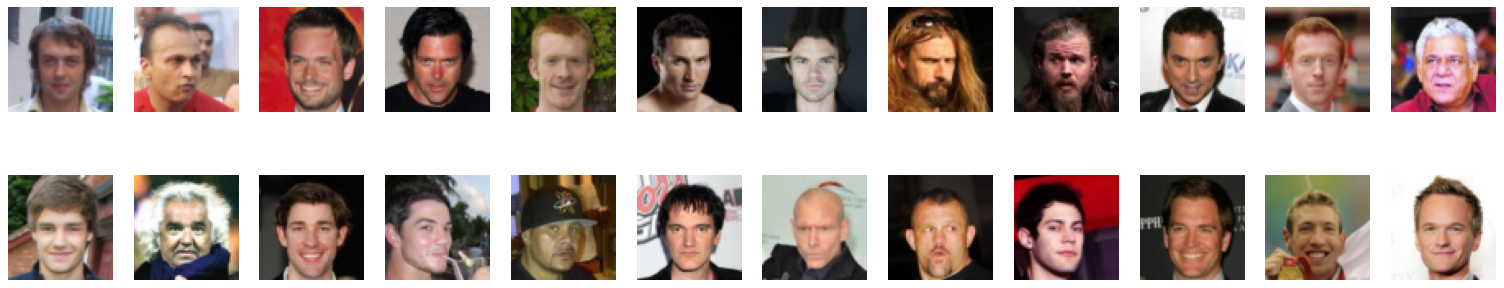

In [2]:
transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])

# show 2 rows of 12 images from train dataset
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(train_dataset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [3]:
z_dim = 1024
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 3

encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)
encoder._build_fc_if_needed(16, 16)
decoder._build_fc_if_needed(16, 16)

In [4]:
autoencoder = Autoencoder(encoder, decoder).to(device)

autoencoder.reconstruction_loss = torch.nn.L1Loss()

In [5]:
bs = 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)

In [6]:
# If you want to load a model from checkpoint, uncomment the following lines:

# conformal_autoencoder.encoder._build_fc_if_needed(16,16)
# conformal_autoencoder.decoder._build_fc_if_needed(16,16)
# conformal_autoencoder.load_model_from_checkpoint("models/path.pth")

In [7]:
# if you want to load optimizer and scheduler state from checkpoint, uncomment the following lines (and include optimizer and scheduler in train_model call):

# optimizer = torch.optim.Adam(conformal_autoencoder.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
# optimizer.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_optimizer.pth"))
# scheduler.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_scheduler.pth"))


In [8]:
epochs = 400
optimizer, scheduler = autoencoder.train_model(train_loader,
                                                         val_loader,
                                                         has_label=True,
                                                         epochs=epochs,
                                                         batch_size=bs,
                                                         learning_rate=1e-3,
                                                         val_every=10,
                                                         scheduler_kwargs={"step_size":20, "gamma":0.85}
                                                         )

Epoch [10/400], Validation Loss: 0.03751148


Epoch [20/400], Validation Loss: 0.03154184


Epoch [30/400], Validation Loss: 0.02908605


Epoch [40/400], Validation Loss: 0.02709913


Epoch [50/400], Validation Loss: 0.02683674


Epoch [60/400], Validation Loss: 0.02497947


Epoch [70/400], Validation Loss: 0.02522465


Epoch [80/400], Validation Loss: 0.02388084


Epoch [90/400], Validation Loss: 0.02282390


Epoch [100/400], Loss: 0.02392918


Epoch [100/400], Validation Loss: 0.02268646


Epoch [110/400], Validation Loss: 0.02214993


Epoch [120/400], Validation Loss: 0.02232200


Epoch [130/400], Validation Loss: 0.02238615


Epoch [140/400], Validation Loss: 0.02202969


Epoch [150/400], Validation Loss: 0.02126251


Epoch [160/400], Validation Loss: 0.02134236


Epoch [170/400], Validation Loss: 0.02122340


Epoch [180/400], Validation Loss: 0.02109578


Epoch [190/400], Validation Loss: 0.02109641


Epoch [200/400], Loss: 0.02139573


Epoch [200/400], Validation Loss: 0.02094000


Epoch [210/400], Validation Loss: 0.02080466


Epoch [220/400], Validation Loss: 0.02089329


Epoch [230/400], Validation Loss: 0.02073161


Epoch [240/400], Validation Loss: 0.02073424


Epoch [250/400], Validation Loss: 0.02052791


Epoch [260/400], Validation Loss: 0.02050746


Epoch [270/400], Validation Loss: 0.02041846


Epoch [280/400], Validation Loss: 0.02048955


Epoch [290/400], Validation Loss: 0.02039287


Epoch [300/400], Loss: 0.02061873


Epoch [300/400], Validation Loss: 0.02047546


Epoch [310/400], Validation Loss: 0.02035381


Epoch [320/400], Validation Loss: 0.02035019


Epoch [330/400], Validation Loss: 0.02026688


Epoch [340/400], Validation Loss: 0.02025811


Epoch [350/400], Validation Loss: 0.02020944


Epoch [360/400], Validation Loss: 0.02022040


Epoch [370/400], Validation Loss: 0.02015802


Epoch [380/400], Validation Loss: 0.02018418


Epoch [390/400], Validation Loss: 0.02014454


Epoch [400/400], Loss: 0.02030740


Epoch [400/400], Validation Loss: 0.02016895


In [ ]:
autoencoder.save_checkpoint("models/celeba_autoencoder_v1_1.pth") # z_dim = 1024, L1Loss, base_ch=32, gap_ch=3

Checkpoint saved to models/celeba_autoencoder_v1_1.pth at epoch 401


In [10]:
torch.save(optimizer.state_dict(), "models/celeba_autoencoder_v1_1_optimizer.pth")
torch.save(scheduler.state_dict(), "models/celeba_autoencoder_v1_1_scheduler.pth")

In [11]:
#get current learning rate
for param_group in optimizer.param_groups:
    current_lr = param_group['lr']
    break
print(f"Current learning rate: {current_lr}")

Current learning rate: 3.875953108451434e-05


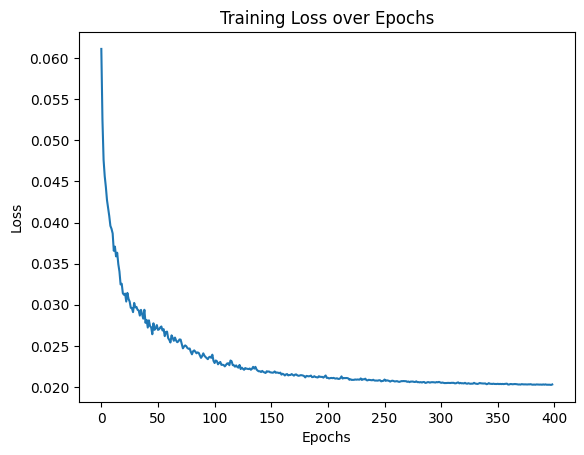

In [27]:
plt.plot(autoencoder.metrics_list["reconstruction_loss"][1:], label="Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

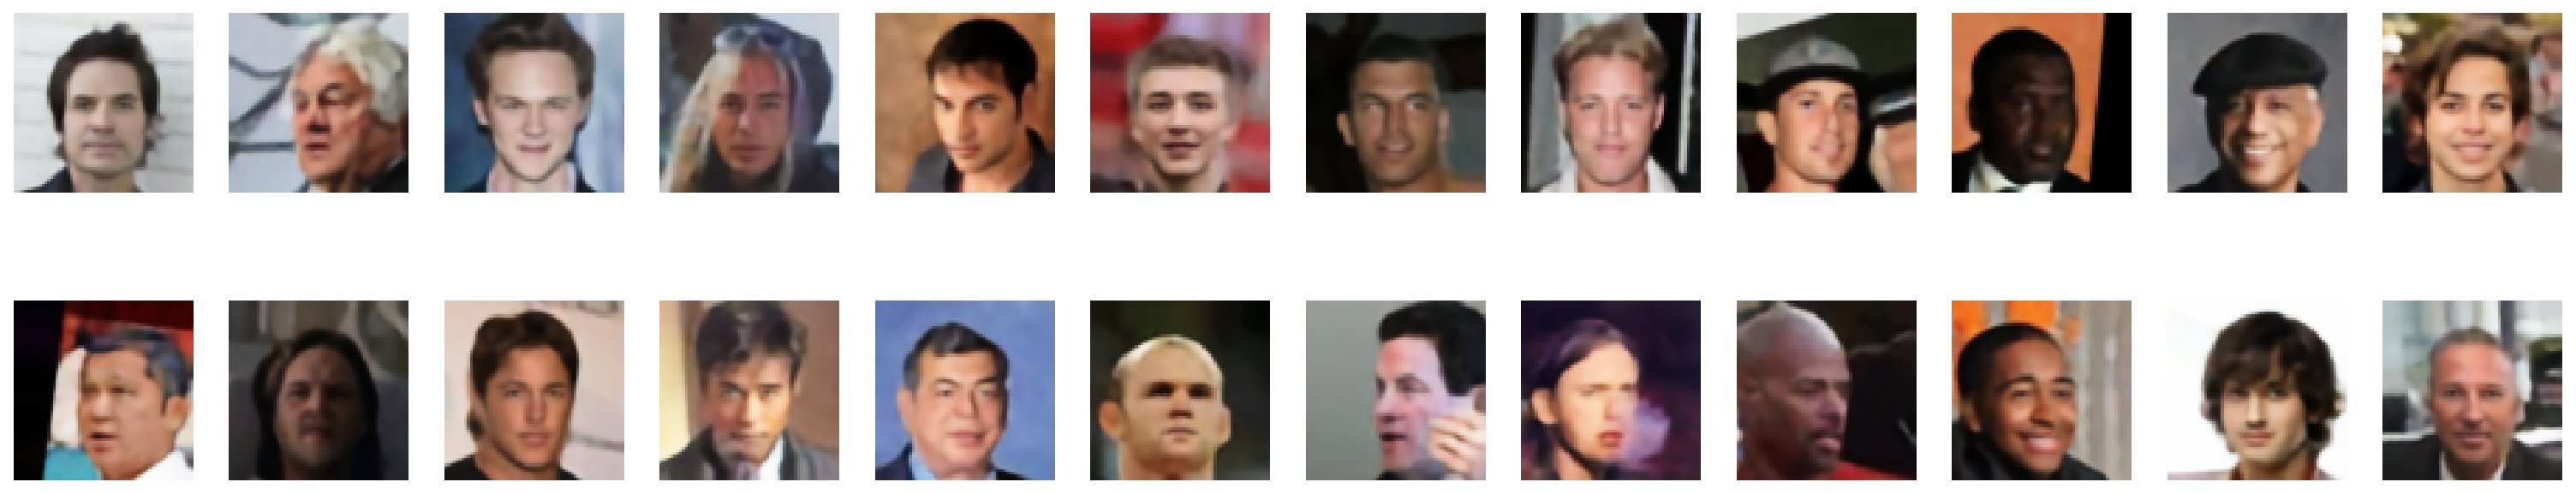

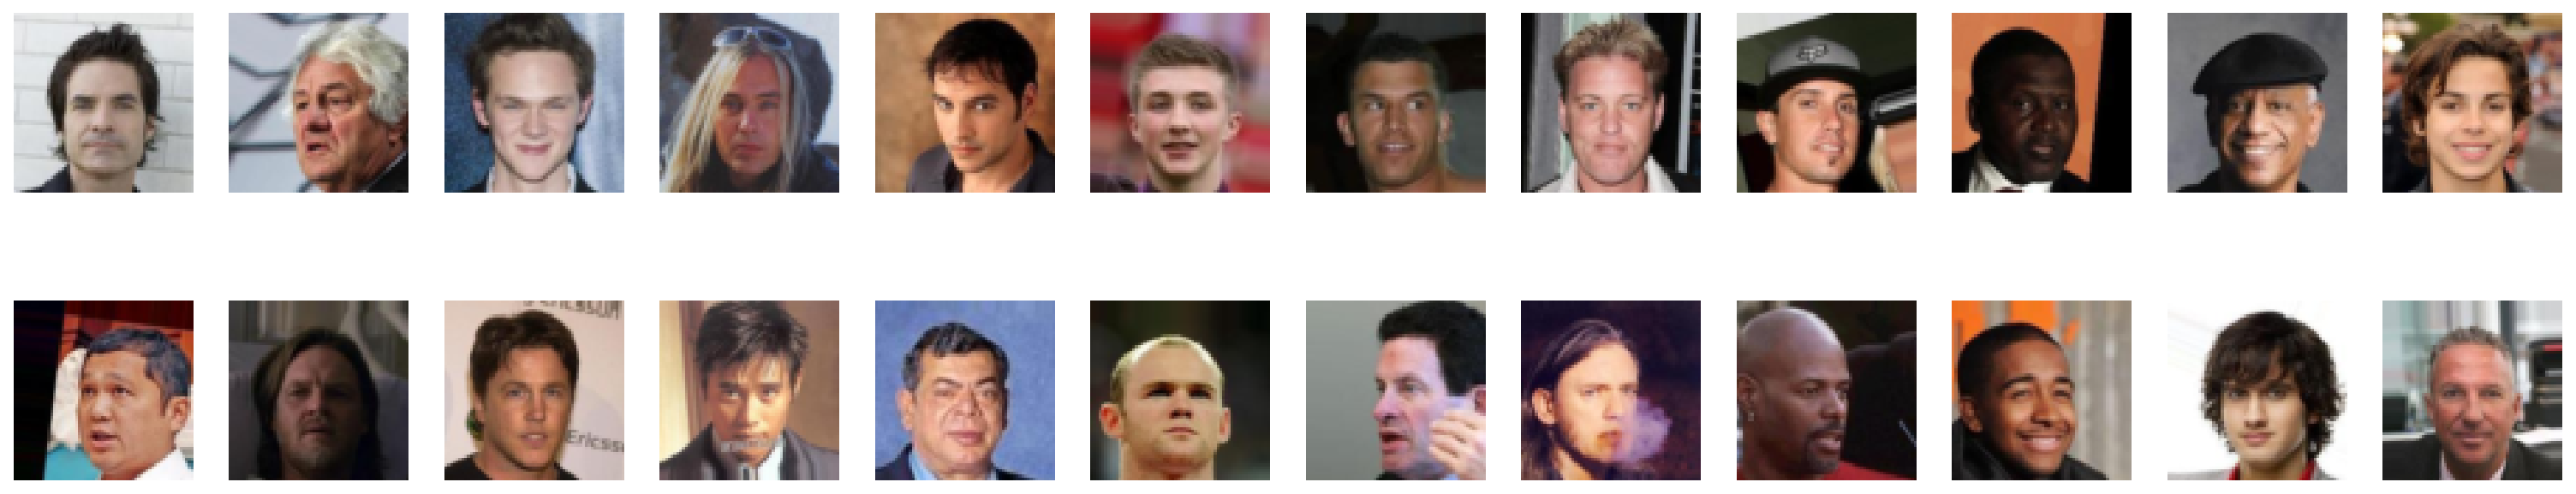

In [15]:
samples = autoencoder.forward(val_dataset.get_sample(24, seed=32)[0].to(device))
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(samples[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(val_dataset.get_sample(24, seed=32)[0][i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

In [28]:
from metrics_copy import evaluate_conformality

evaluate_conformality(autoencoder, val_dataset.get_sample(50, seed=42)[0].to(device), chunk_size=64, jacrev_chunk_size=64)

tensor([-0., -0., 0., -0., 0., -0., 0., 0., 0., -0., 0., -0., -0., -0., 0., 0., 0., -0., -0., 0., -0., 0., 0., 0.,
        -0., -0., -0., 0., -0., -0., 0., -0., 0., -0., 0., 0., 0., 0., -0., 0., -0., 0., -0., 0., 0., 0., -0., 0.,
        -0., -0.], device='cuda:1', dtype=torch.float64)
tensor([2.7198e-147,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         7.0483e-50,  0.0000e+00, 1.2422e-154,  0.0000e+00, 2.6008e-135,
         0.0000e+00, 4.0359e-115, 3.1733e-152, 5.4050e-112,  0.0000e+00,
         2.9816e-69,  0.0000e+00, 1.8580e-116,  0.0000e+00,  0.0000e+00,
        4.7949e-160,  0.0000e+00,  0.0000e+00, 1.3275e-118,  0.0000e+00,
        2.8126e-145, 9.4450e-117, 3.7193e-144, 6.7150e-125,  0.0000e+00,
         0.0000e+00, 1.0081e-101,  6.1271e-78, 4.9355e-125,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, 4.3147e-119, 4.3480e-115,
        3.4190e-144, 4.4041e-114,  0.0000e+00,  0.0000e+

{'Reconstruction Error': 0.0010197028750553727,
 'Diagonal Uniformity (gini)': 0.07299362868070602,
 'Conformal Factor Mean': 0.47599318623542786,
 'Conformal Factor Std': 0.13159996271133423,
 'Conformal Factor Std (normalized)': 0.2764744758605957,
 'Conformal Factor Estimate Error': 0.007240686099976301,
 'Conformal Factor Estimate Error (normalized)': 0.015211739577353,
 'Off-diagonal Mean': 0.016597790643572807,
 'Off-diagonal Mean (normalized)': 0.035992659628391266,
 'Off-diagonal Norm': 21.90654182434082,
 'Off-diagonal Norm (normalized)': 47.53329849243164,
 'Conformality Mean': 0.016643645241856575,
 'Conformality Mean (normalized)': 0.0360909067094326,
 'Conformality Norm': 22.0004825592041,
 'Conformality Norm (normalized)': 47.73314666748047,
 'Determinant Estimation Error': 1.409652707098222e-51,
 'Determinant Estimation Error (normalized)': 1.18250239759858e-44,
 'Determinant Estimation from Estimate Error': 2.6287661178538526e-48,
 'Determinant Estimation from Estimate 

In [18]:
def compute_full_jacobian_per_sample(func, z, device=None):
    """
    Compute full Jacobian for each sample sequentially (low peak memory).
    Returns a list of jacobians (tensor per sample) or writes them to disk.
    Warning: each jacobian is large (O(output_dim * latent_dim)).
    """
    jacobians = []
    for i in range(z.size(0)):
        zi = z[i:i+1]  # (1, L)
        # compute jacobian of flattened outputs wrt input vector zi
        def single_out(x):
            return func(x).view(-1)   # returns (out_dim,)
        Ji = torch.autograd.functional.jacobian(single_out, zi, create_graph=False)  # shape (out_dim, 1, L) maybe
        Ji = Ji.view(-1, zi.size(1))  # (out_dim, L)
        jacobians.append(Ji)
        # optionally torch.save(Ji.cpu(), f'jac_{i}.pt') and del Ji to free memory
    return jacobians

In [20]:
latent = autoencoder.encoder(val_dataset.get_sample(1, seed=42)[0].to(device))

In [21]:
jacobians = compute_full_jacobian_per_sample(autoencoder.decoder, latent)

In [22]:
jacobians = torch.stack(jacobians) 

In [23]:
JtJs = torch.einsum('bji,bjk->bik', jacobians, jacobians)

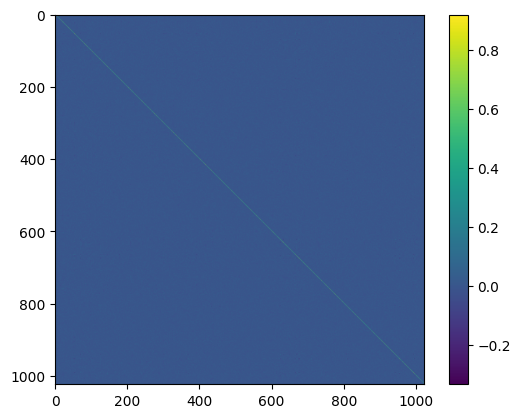

In [24]:
plt.imshow(JtJs[0].cpu().detach())
plt.colorbar()
plt.show()